# Time Series Anomaly Detection
__Thursday 11/5/2020__

### Dataset: Codeup curriculum access logs
Our dataset contains approximately 3 years of unique timestamped access events to Codeup's cirriculum.


| Features | Description | dtype |
| :------ | :----------- | :---- |
| `datetime` | Index of the dataset. The date and time a page was viewed by a user | DatetimeIndex |
| `page_viewed` | The content the user accessed |
| `user_id` | The user who accessed the curriculum |
| `cohort_id` | The cohort the user is assigned to |
| `ip` | The ip address the user is using to access the curriculum |


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns

# import data wrangle functions
import main
import acquire
import prepare

# Wrangle

In [2]:
# load the dataset
df = acquire.get_cohort_log_data()

In [3]:
df = prepare.prep_curriculum_log_data(df)

In [4]:
print(f'There are {df.shape[0]:,} rows and {df.shape[1]} features in the dataset.')
# display the first 5 rows
df.head()

There are 719,459 rows and 4 features in the dataset.


,page_viewed,user_id,cohort_id,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


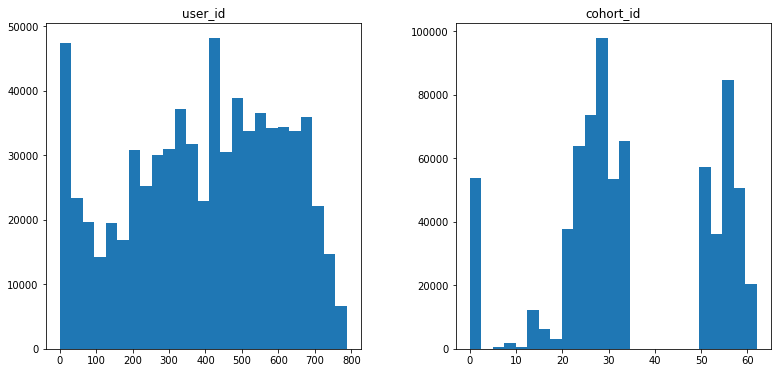

In [5]:
df.hist(figsize=(13, 6),
        grid=False,
        bins=25);

In [6]:
# df.page_viewed.str.replace(r'[-_].*', '').value_counts().nlargest(20)

# Exploratory Data Analysis

In [7]:
df_agg = df.groupby(['datetime', 'cohort_id'])['user_id'] \
                    .nunique() \
                    .reset_index() \
                    .rename(index=str, 
                            columns={'user_id': 'users_viewed'}) \
                    .set_index('datetime')

In [8]:
df_agg.head()

,cohort_id,users_viewed
datetime,,
2018-01-26 09:55:03,8,1
2018-01-26 09:56:02,8,1
2018-01-26 09:56:05,8,1
2018-01-26 09:56:06,8,1
2018-01-26 09:56:24,22,1


In [9]:
train_size = int(len(df_agg) * .5)
validate_size = int(len(df_agg) * .3)
test_size = int(len(df_agg) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_agg[: train_size]
validate = df_agg[train_size : validate_end_index]
test = df_agg[validate_end_index : ]

print(f'Train size: {len(train) / len(df_agg):.2%}')
print(f'Validate size: {len(validate) / len(df_agg):.2%}')
print(f'Test size: {len(test) / len(df_agg):.2%}')

Train size: 50.00%
Validate size: 30.00%
Test size: 20.00%


In [10]:
train.head()

,cohort_id,users_viewed
datetime,,
2018-01-26 09:55:03,8,1
2018-01-26 09:56:02,8,1
2018-01-26 09:56:05,8,1
2018-01-26 09:56:06,8,1
2018-01-26 09:56:24,22,1


In [11]:
# create hourly aggregated datasets
train_hourly_1hr = train.resample('H').users_viewed.agg(['sum'])
train_hourly_6hrs = train.resample('6H').users_viewed.agg(['sum'])
train_hourly_12hrs = train.resample('12H').users_viewed.agg(['sum'])

train_hourly_1hr.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_hourly_6hrs.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_hourly_12hrs.rename(columns={'sum': 'times_viewed'}, inplace=True)

train_hourly_1hr['hour'] = train_hourly_1hr.index.hour
train_hourly_6hrs['hour'] = train_hourly_6hrs.index.hour
train_hourly_12hrs['hour'] = train_hourly_12hrs.index.hour

train_hourly_1hr['access_type'] = pd.cut(train_hourly_1hr['hour'],
                                         bins=[0, 9, 17, 24],
                                         labels=['Before Class', 'During Class', 'After Class'])

train_daily_1d = train.resample('D').users_viewed.agg(['sum'])

train_daily_1d.rename(columns={'sum': 'times_viewed'}, inplace=True)
train_daily_1d['day_of_week'] = train_daily_1d.index.day_name()

# Hourly Logs

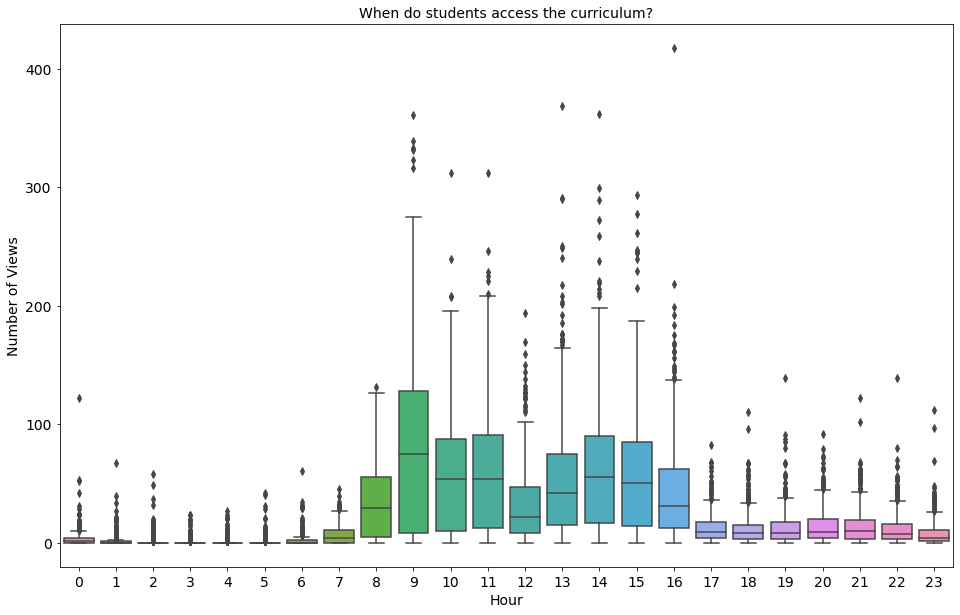

In [20]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr['hour'],
            y=train_hourly_1hr.times_viewed)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Number of Views', fontsize=14);

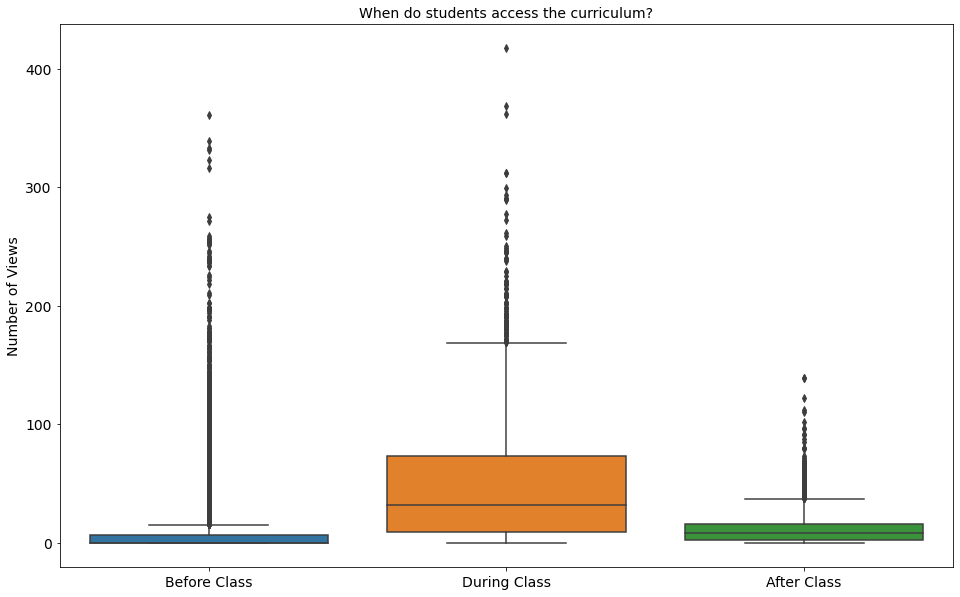

In [21]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_1hr.access_type,
            y=train_hourly_1hr.times_viewed)
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);

In [14]:
train_hourly_1hr.head()

,times_viewed,hour,access_type
datetime,,,
2018-01-26 09:00:00,11,9,Before Class
2018-01-26 10:00:00,62,10,During Class
2018-01-26 11:00:00,101,11,During Class
2018-01-26 12:00:00,27,12,During Class
2018-01-26 13:00:00,52,13,During Class


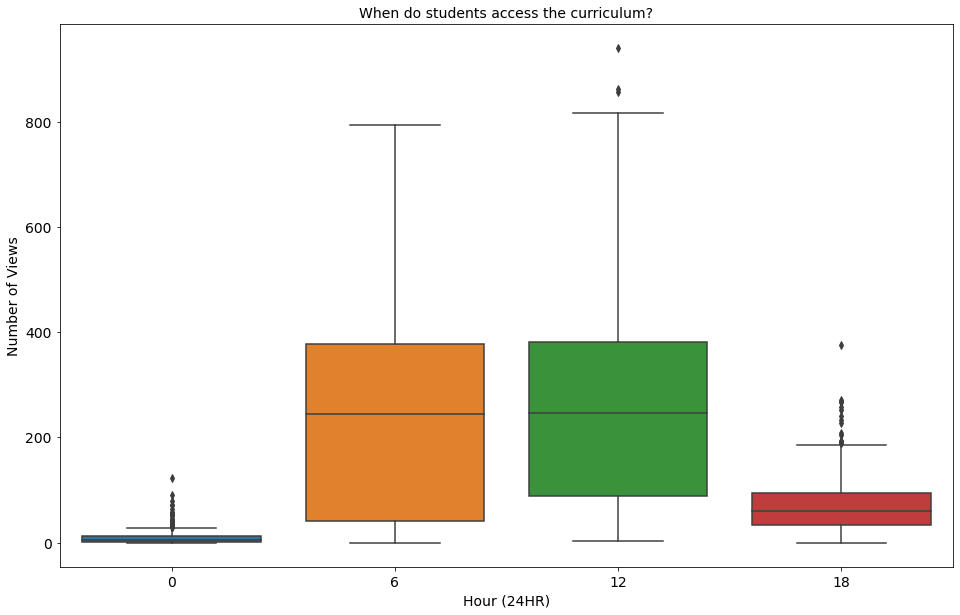

In [22]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_hourly_6hrs['hour'],
            y=train_hourly_6hrs['times_viewed'])
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Hour (24HR)', fontsize=14)
plt.ylabel('Number of Views', fontsize=14);

In [16]:
train_hourly_6hrs.head()

,times_viewed,hour
datetime,,
2018-01-26 06:00:00,174,6
2018-01-26 12:00:00,245,12
2018-01-26 18:00:00,144,18
2018-01-27 00:00:00,20,0
2018-01-27 06:00:00,51,6


# Daily Logs

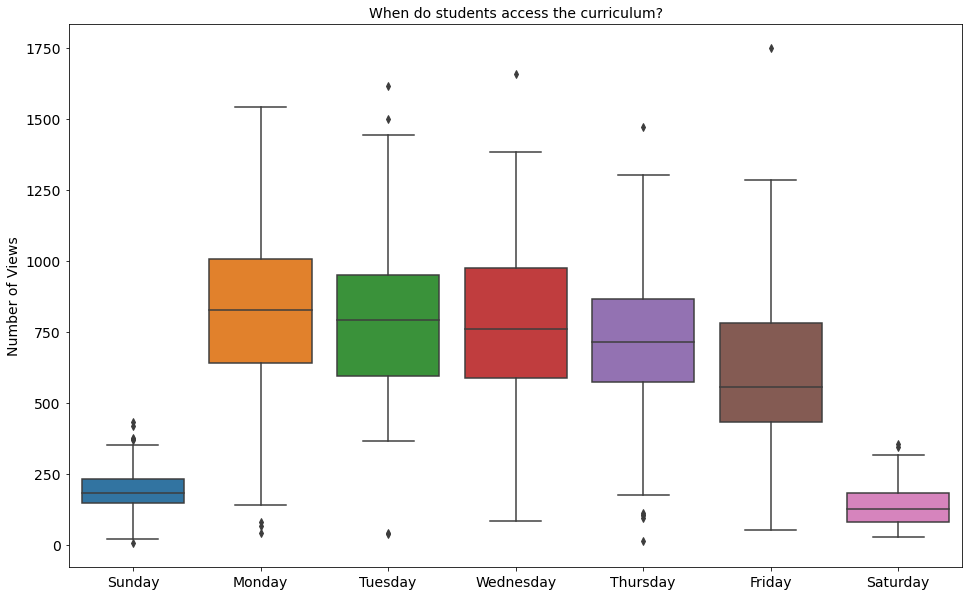

In [23]:
plt.figure(figsize=(16,10))
sns.boxplot(x=train_daily_1d.day_of_week,
            y=train_daily_1d['times_viewed'],
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('When do students access the curriculum?', fontsize=14)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('')
plt.ylabel('Number of Views', fontsize=14);

In [18]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [19]:
compute_entropy(df_agg.users_viewed)

0.05747288500141831